**Imports and global settings**

In [191]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iris:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F19%2F420%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T165259Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D78b6aed4d035f52d2c0a18c7a6b414809fed5383d772ccf3931f0678a484965ea0230dfcd9018f2b405577c64ae931da06c7c49eac2bd216a7a3d8604ba5548b63167781db14a99663b6b20cc622caef9653a9fed04133b9edcca88a7a3f13f156b441c852ed4129a4922bcaf93e5f41156de522f7a328fdda82069cb9959db27b529a0a9b935b1d36e604cdd56edc8d6bdece2d47fa307a0a999fffd05e36dc3451ad1c203bc1bcb51504f00ed1bd2c3244911cefc663d25cccec99d45f55d0b8103270292b85e5e5449b6254066f25aebbcaf1b5896b38d2a86cf19b441eaba42fcb0adb0de6240cbbf3e6a06f4da1851f6f878add98ef0936df45575680fc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 3687 bytes downloaded
Downloaded and uncompressed: iris
Data source import complete.


In [192]:
import numpy as np
import pandas as pd
#!pip install umap
#!pip install umap-learn

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

# EDA

**Reading in the dataset**

In [193]:
df = pd.read_csv('/kaggle/input/iris/Iris.csv')

df.head()


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


**Any duplicate rows?**

In [194]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0


**Any missing values?**

In [195]:
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

**Checking data types**

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


**Cleaning up column names (mainly for handling purposes)**

In [197]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

# sanity check
df.head()

,id,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm,species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


**Quick overview over the individual distributions**

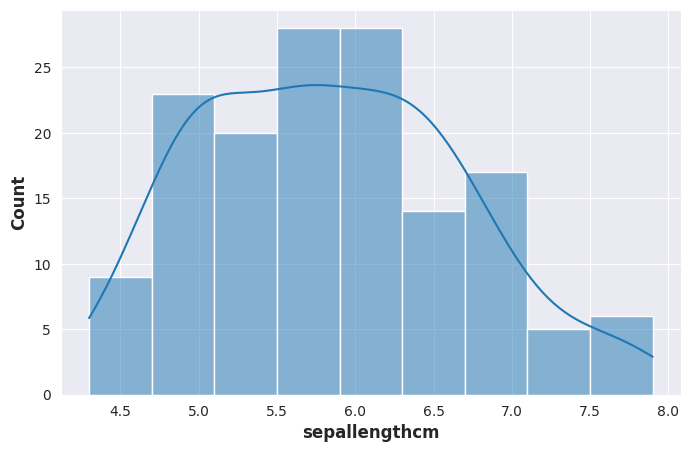

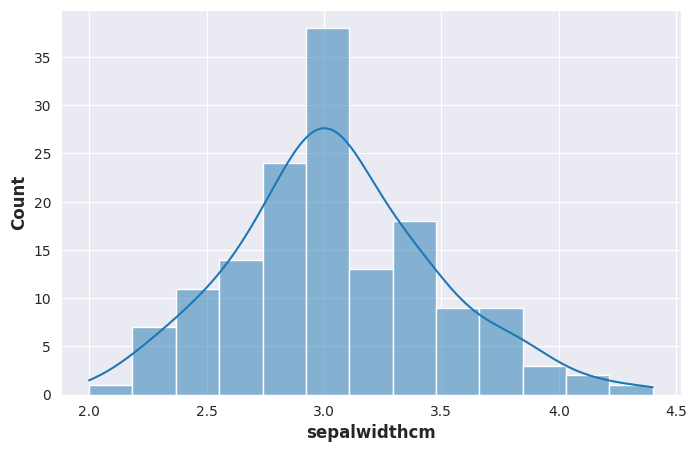

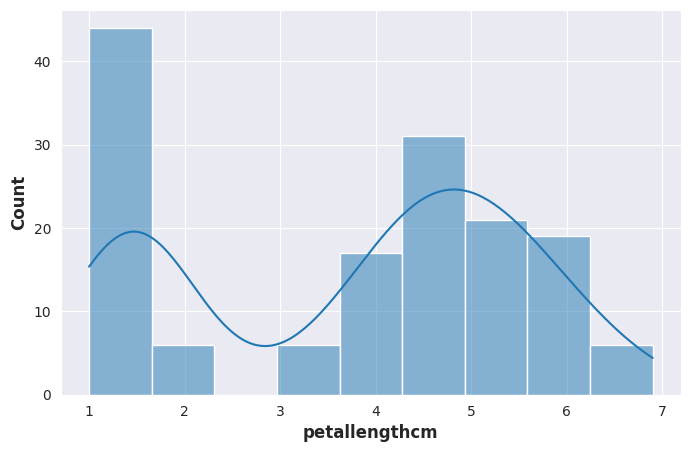

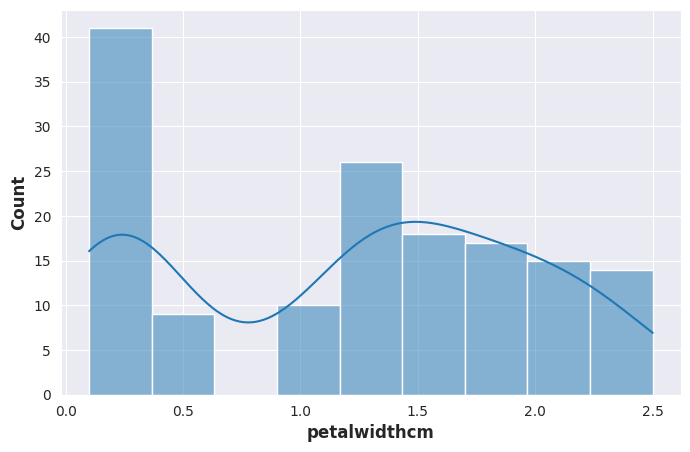

In [198]:
for col in df.select_dtypes(include=[np.number]).drop(columns=['id']):
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

==> Distributions require scaling and standardization.

# Clustering

In [199]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [200]:
X = df.copy()

In [201]:
X_valnum = df.select_dtypes(include=[np.number]).drop(columns=['id'])
X_tf = StandardScaler().fit_transform(X_valnum)

In [202]:
X_tf2 = PowerTransformer(standardize=False).fit_transform(X_tf)

In [203]:
X = pd.DataFrame(X_tf2, columns=X_valnum.columns)

X.head()

,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm
0,-0.972914,0.963947,-1.121699,-1.219266
1,-1.254819,-0.126271,-1.121699,-1.219266
2,-1.543675,0.329035,-1.162766,-1.219266
3,-1.690529,0.105499,-1.080253,-1.219266
4,-1.112958,1.166559,-1.121699,-1.219266


## Dimensionality reduction via UMAP

Antes de la agrupación, el número de características se reduce de 4 a 2. La razón principal detrás de esto es poder "ver" directamente si los grupos identificados tienen sentido. Además de esto, las métricas de similitud tienden a funcionar mejor en dimensiones más bajas (las medidas de distancia degeneran para una gran cantidad de características de entrada) y esta reducción de dimensionalidad también mitiga la relativamente pobre "relación entre observaciones y características" para este conjunto de datos.

In [204]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

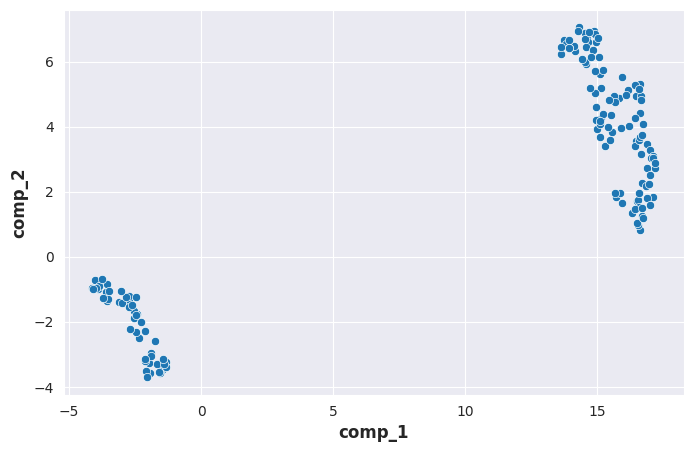

In [205]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

## Definition of plotting and convergence check function

In [206]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.

    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.

    Returns
    =======
    None
    Prints a figure.

    """

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

**Algo 1: K-means**

K-means es el algoritmo de Clustering más conocido y "básico". Su hiperparámetro más importante es n_clusters, que es el número de clústeres que debe buscar el algoritmo.

In [207]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

Identificar el número "óptimo" de clústeres


En el contexto de clustering mediante K-medias, la suma de las distancias al cuadrado de los puntos a sus respectivos centroides se conoce como "**inercia**". Encontrar un número apropiado de conglomerados aquí significa encontrar el punto de rendimientos decrecientes al aumentar el número de centroides. Esto se hace visualmente mediante la identificación de un posible problema en el gráfico de inercia versus número de grupos.

In [208]:
inertias_1 = []
range_clusters_1 = np.arange(2, 6, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state, n_init = 10).fit(X)
    inertia = kmeans_1.inertia_
    inertias_1.append(inertia)
    print(f"Inercia con {n} clusters: {inertia}")

Inercia con 2 clusters: 520.9994506835938
Inercia con 3 clusters: 225.5531463623047
Inercia con 4 clusters: 145.20469665527344
Inercia con 5 clusters: 83.23590850830078


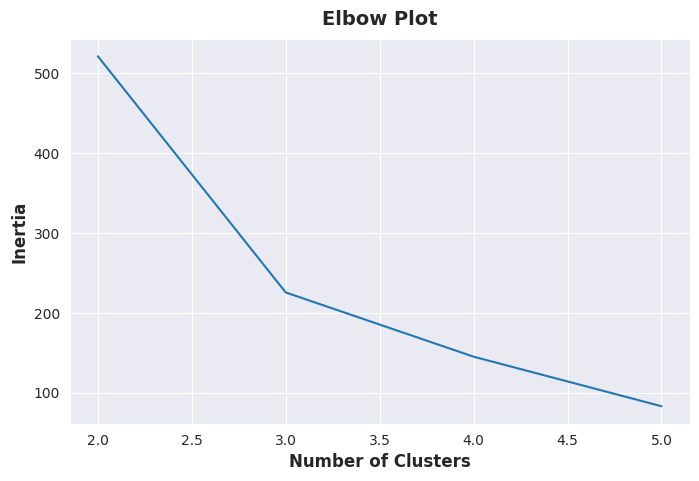

In [209]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

==> "Codo" saliente en 3 grupos. Este es, por tanto, el número de grupos a elegir. Como se analizó anteriormente, esto está en la línea de lo que se esperaría con solo mirar los datos.

### Run with optimised *n_clusters*

In [210]:
%%time

start_time = time.time()

kmeans = KMeans(n_clusters=3, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 2, max_iter: 300

CPU times: user 53.9 ms, sys: 955 µs, total: 54.8 ms
Wall time: 48.4 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


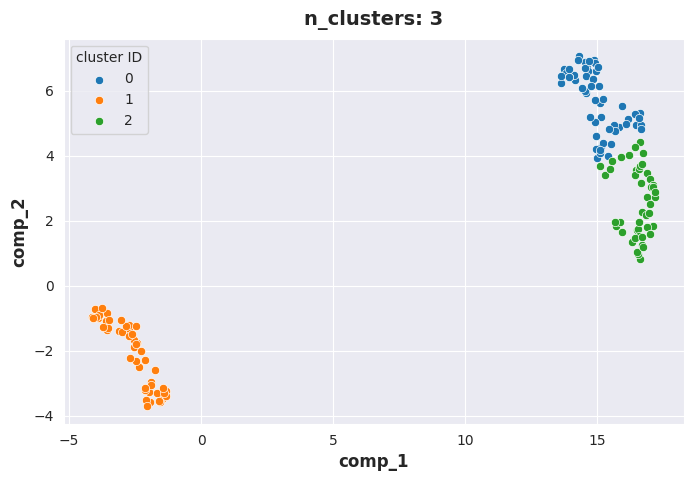

In [211]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

Esos resultados parecen muy razonables. Esto no es inesperado ya que la estructura de los datos es tal que no choca con los supuestos fundamentales de K-medias, es decir, que los grupos forman (hiper)esferas no superpuestas (es decir, "círculos" en 2D) de aproximadamente el mismo extensión (y el conjunto de datos no contiene un número "excesivo" de valores atípicos).

## Algo 2: Mean shift

Similar a K-medias, el desplazamiento medio es un algoritmo basado en centroides. Sin embargo, a diferencia de K-means, no es necesario especificar el número de grupos por adelantado. Su principal hiperparámetro es el ancho de banda, que representa la extensión de las "regiones de búsqueda local". Sin embargo, si este parámetro no se especifica, sklearn proporciona una estimación del mismo. Además, el cambio medio también viene con la opción de no asociar necesariamente todos los puntos de datos con un clúster configurando cluster_all en False. Este aspecto del algoritmo también se explora a continuación.

In [212]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Vanilla run (defaults for all hyperparameters)

In [213]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Algorithm converged successfully!
n_iter: 8, max_iter: 300

CPU times: user 217 ms, sys: 89.9 ms, total: 307 ms
Wall time: 2.87 s


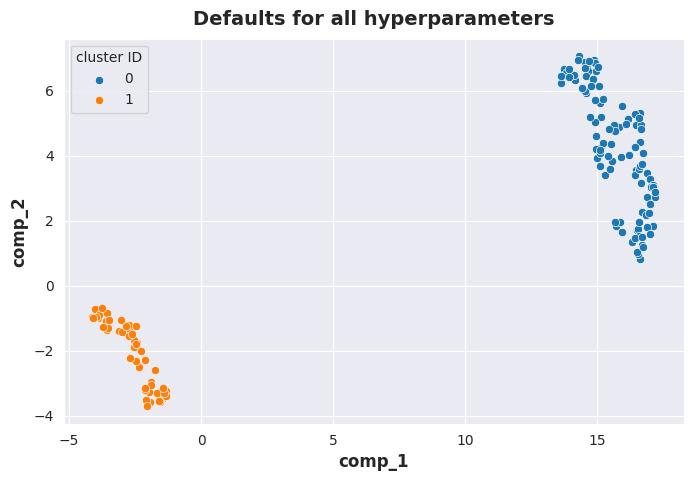

In [214]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

La estimación del ancho de banda parece funcionar bien aquí. Por tanto, no es necesario realizar ningún ajuste adicional de este hiperparámetro.

### Allowing for 'noise'

This is enabled by setting *cluster_all=False*.

In [215]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 8, max_iter: 300

CPU times: user 161 ms, sys: 8.17 ms, total: 169 ms
Wall time: 416 ms


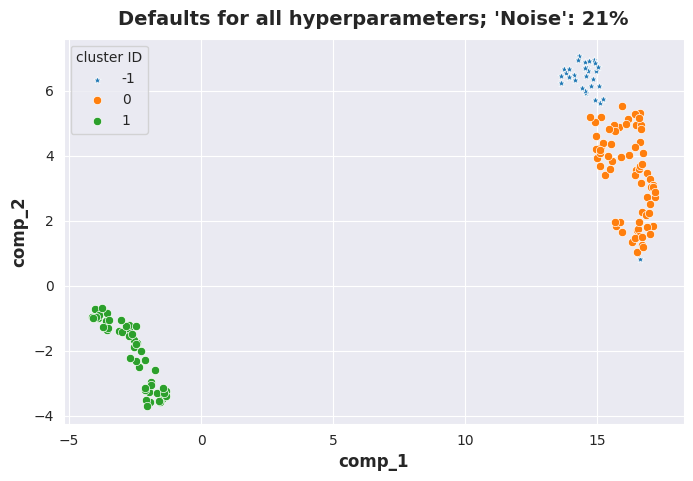

In [216]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Los puntos de datos que el algoritmo identifica como "que no forman parte de ningún grupo" (es decir, 'ruido' o 'huérfanos') se marcan como estrellas azules (ID del grupo: -1).

==> Los resultados parecen sensatos pero no sustancialmente diferentes de la solución para el cluster_all=True predeterminado para este conjunto de datos.

Ícono de validado por la comunidad

## Algo 3: Gaussian Mixture

El modelo de mezcla gaussiana es, como su nombre indica, un algoritmo basado en distribución. Su hiperparámetro principal es n_components, que corresponde al número de clústeres a formar. Como atajo aquí, se adopta el número de conglomerados identificados en la sección K-medias.

In [217]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [218]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 4, max_iter: 100

CPU times: user 20 ms, sys: 13.9 ms, total: 34 ms
Wall time: 27.5 ms


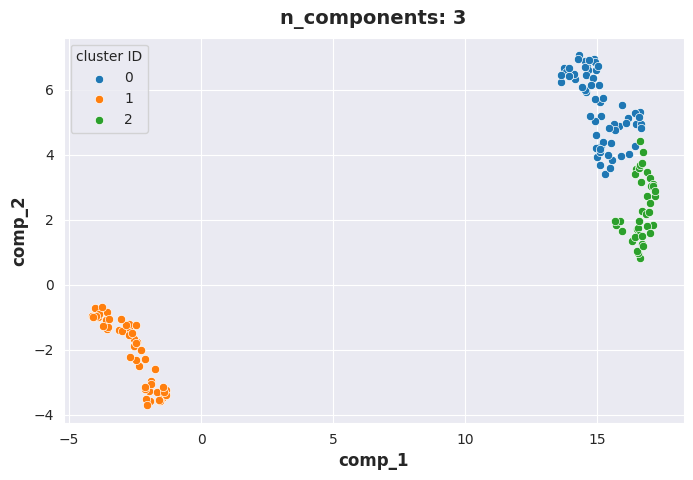

In [219]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

Los resultados parecen bastante razonables. Nuevamente, esto no es del todo inesperado, ya que la estructura de los datos forma más o menos "manchas" elípticas en 2D, que es lo que el modelo de mezcla gaussiana es bastante bueno para capturar.

## Algo 4: Affinity propagation

La propagación por afinidad no requiere especificar la cantidad de clústeres por adelantado. Su principal hiperparámetro es la ***amortiguación***, que es un valor en el rango de 0,5 (incl.) a 1,0 (excl.).

In [220]:
# hyperparamter to tune

affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [221]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

Algorithm converged successfully!
n_iter: 39, max_iter: 200

CPU times: user 34.1 ms, sys: 0 ns, total: 34.1 ms
Wall time: 37.7 ms


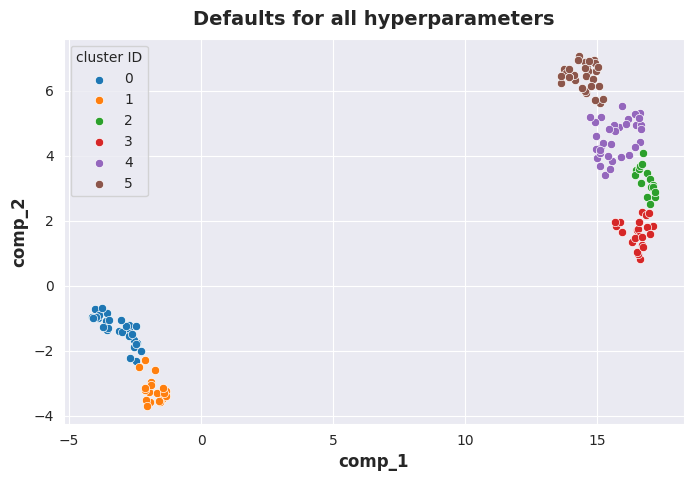

In [222]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

### Tuning runs for "damping"

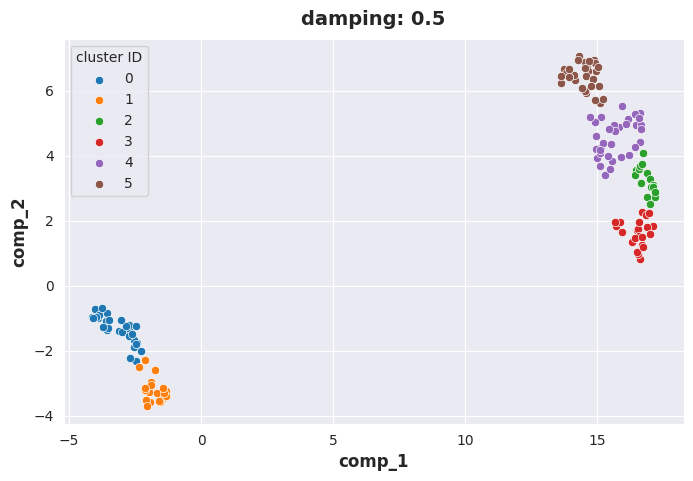

Algorithm converged successfully!
n_iter: 39, max_iter: 500



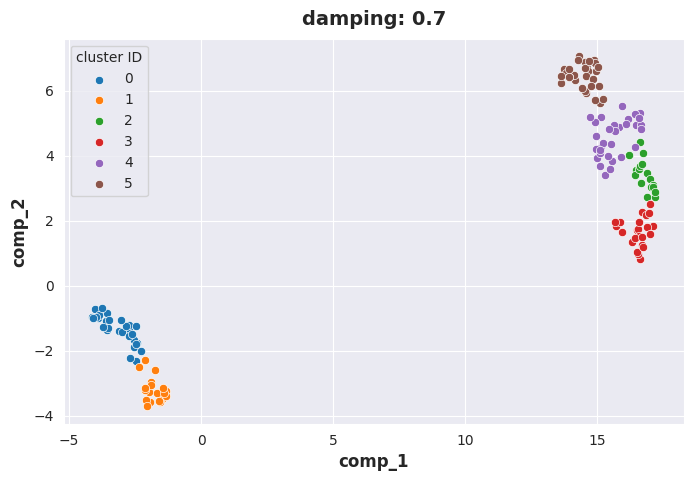

Algorithm converged successfully!
n_iter: 27, max_iter: 500



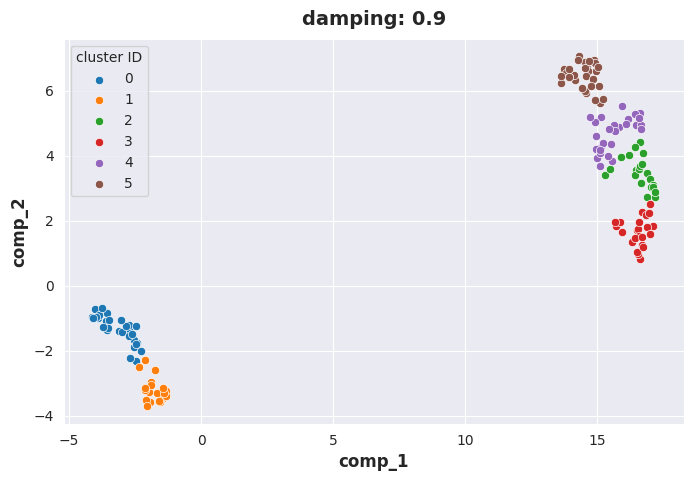

Algorithm converged successfully!
n_iter: 52, max_iter: 500



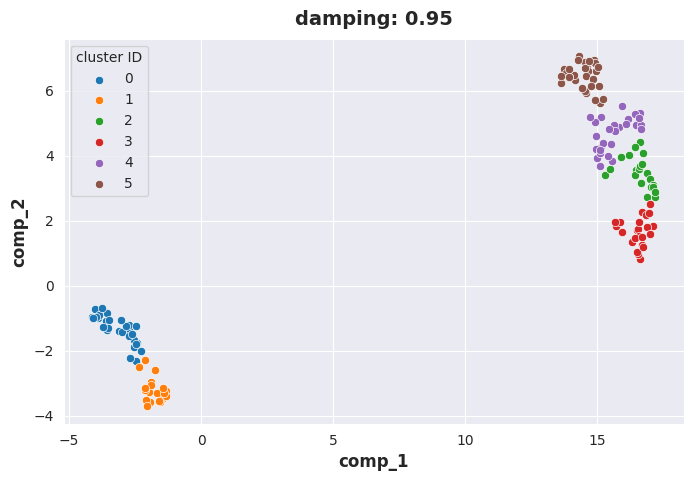

Algorithm converged successfully!
n_iter: 93, max_iter: 500



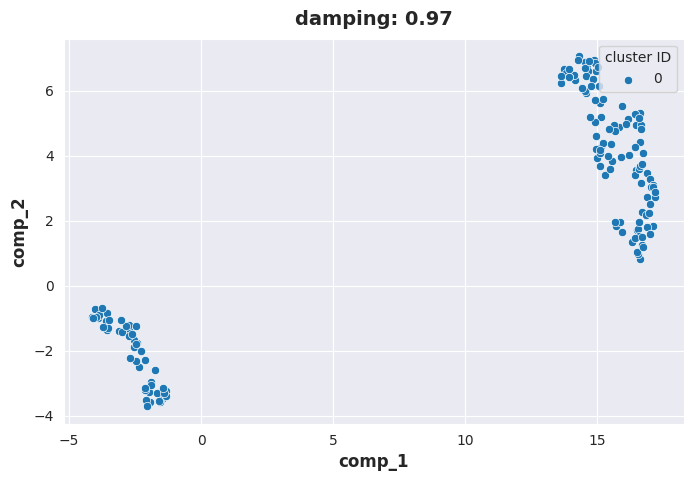

Algorithm converged successfully!
n_iter: 99, max_iter: 500



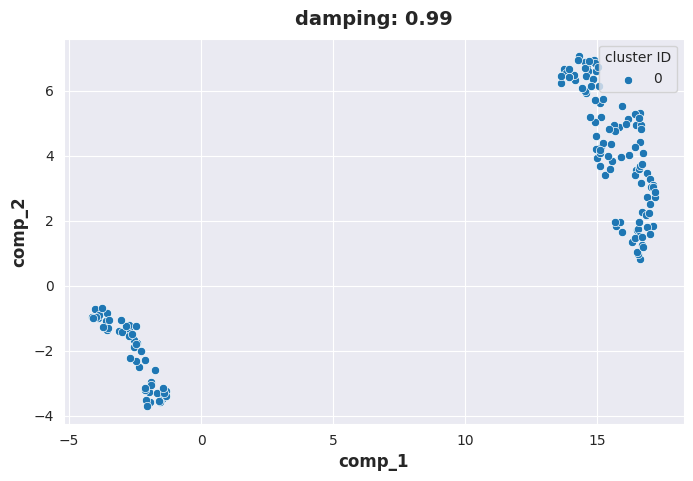

Algorithm converged successfully!
n_iter: 273, max_iter: 500

CPU times: user 3.45 s, sys: 620 ms, total: 4.07 s
Wall time: 3.49 s


In [223]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

==> Tuning "damping" does not seem to be very "effective" for this dataset!

### Tuning runs for "preference"

In order to still get to the "expected solution" of finding 3 clusters, another hyperparamter, ***preference*** is investigated. As stated in the beginning though, the self-imposed contraint here is to only tune a single hyperparameter, leaving all others at their default values, i.e. not looking for any interactions between them.

In [224]:
# hyperparamter to tune

affprop_hparam = "preference"

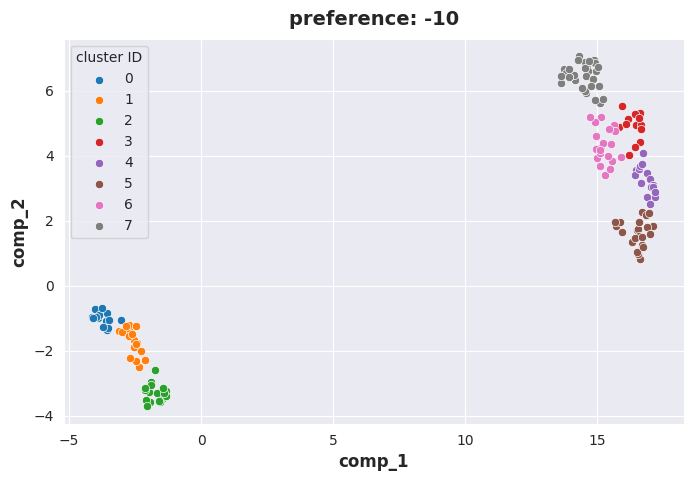

Algorithm converged successfully!
n_iter: 29, max_iter: 500



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


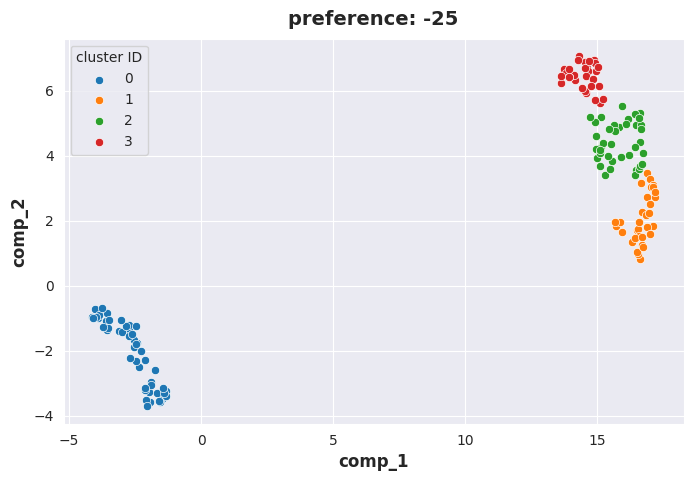

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


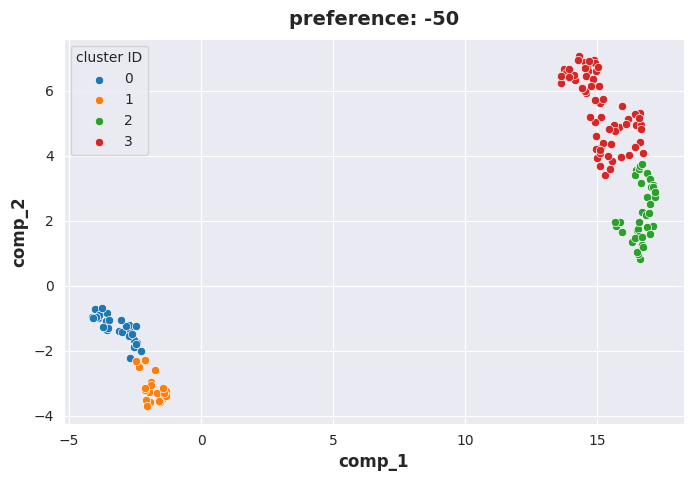

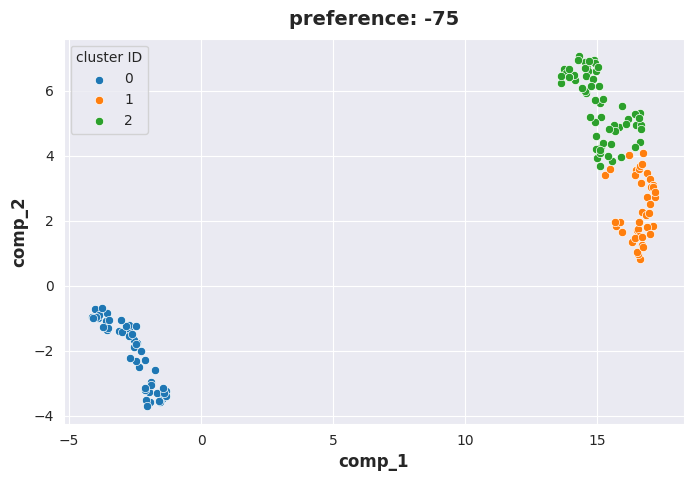

Algorithm converged successfully!
n_iter: 101, max_iter: 500



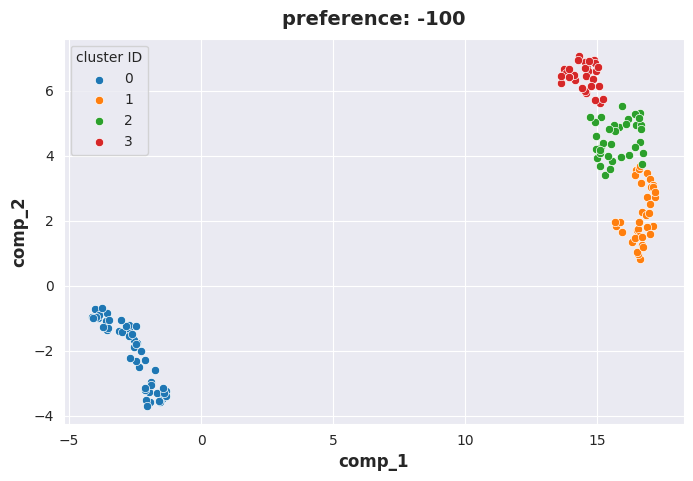

Algorithm converged successfully!
n_iter: 137, max_iter: 500

CPU times: user 3.34 s, sys: 528 ms, total: 3.87 s
Wall time: 3.38 s


In [225]:
%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

==> In contrast to *damping*, *preference* seems to have a much stronger influcence on the number of formed clusters ***for this particular dataset***.

### Re-run with optimised *preference*

In [226]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 358, max_iter: 500

CPU times: user 163 ms, sys: 331 µs, total: 163 ms
Wall time: 167 ms


## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.

In [227]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

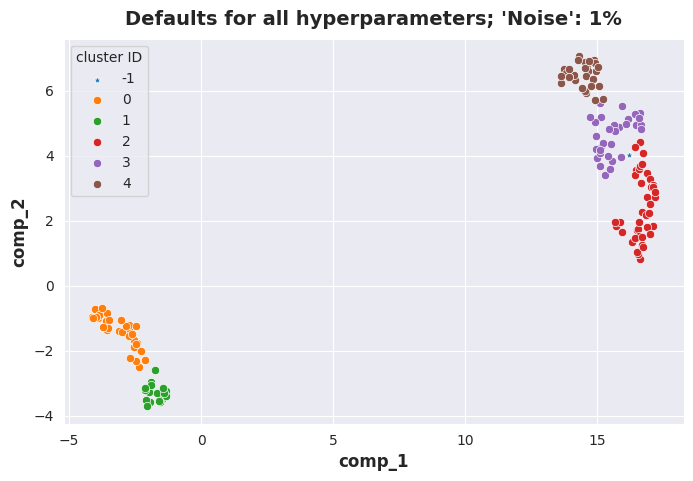

CPU times: user 801 ms, sys: 87.8 ms, total: 888 ms
Wall time: 884 ms


In [228]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The result looks quite convincing! It is important to note here that the structure of data is not at odds with what DBSCAN requires in order to work satisfactorily, i.e. that the **clusters are of a roughly similar density**. Approximately 4% off all datapoints were identified as noise here.

### Tuning runs for *eps*

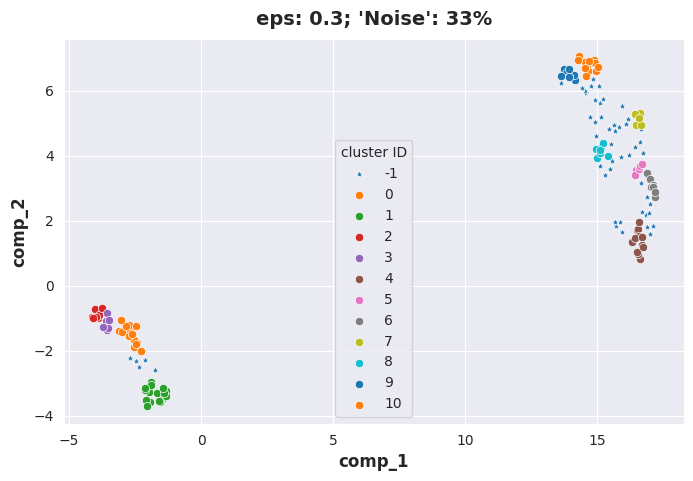

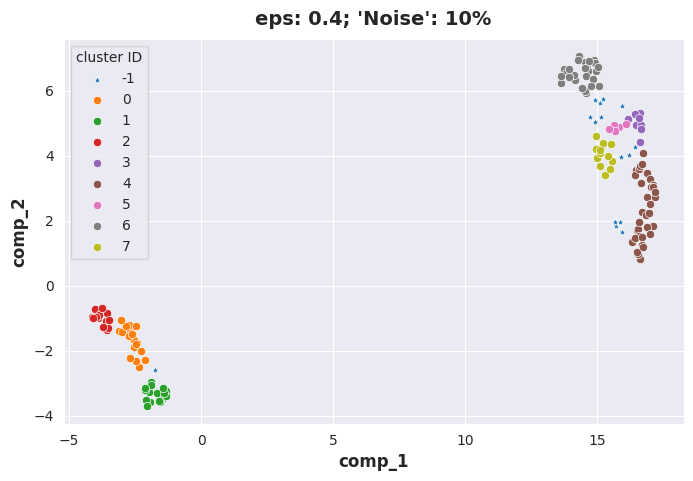

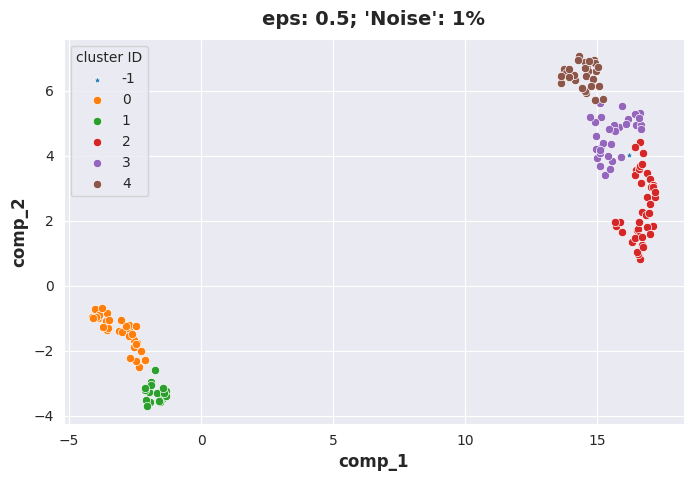

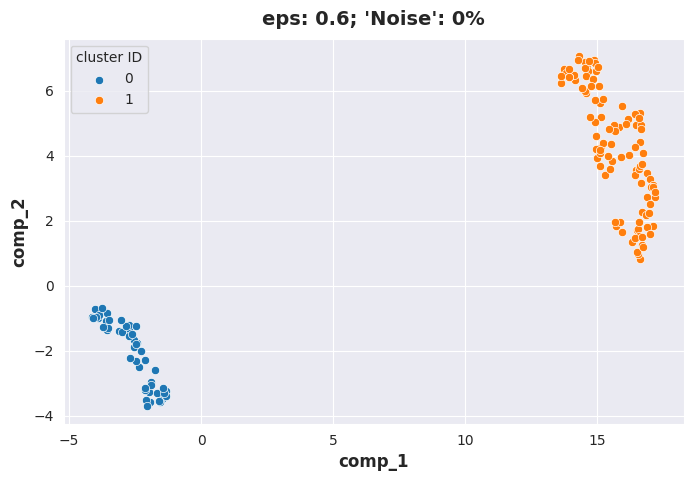

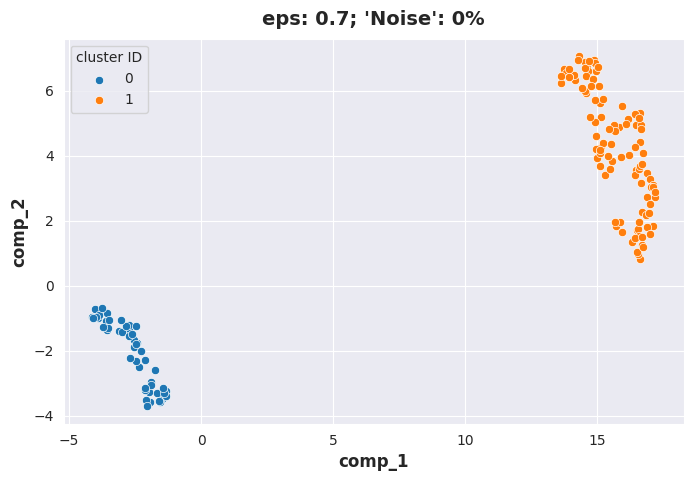

CPU times: user 3.6 s, sys: 492 ms, total: 4.1 s
Wall time: 3.85 s


In [229]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

==> The algorithm shows quite a high sensitivity to ***eps***. A value of around 0.6 seems to work best for this particular dataset.

### Re-run with optimised *eps*

In [230]:
%%time

eps_val = 0.6

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 10.7 ms, sys: 823 µs, total: 11.5 ms
Wall time: 25.7 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

In [231]:
# hyperparamter to tune

optics_hparam = "min_samples"

### Vanilla run (defaults for all hyperparameters)

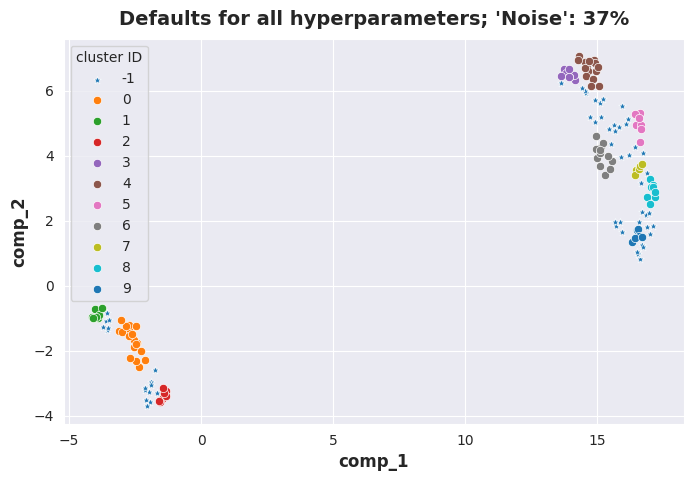

CPU times: user 2.29 s, sys: 318 ms, total: 2.61 s
Wall time: 3.92 s


In [232]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The algorithm identified a considerable number of clusters. Furthermore, a substantial partion of the dataset is labelled as "noise".

### Tuning runs for *min_samples*

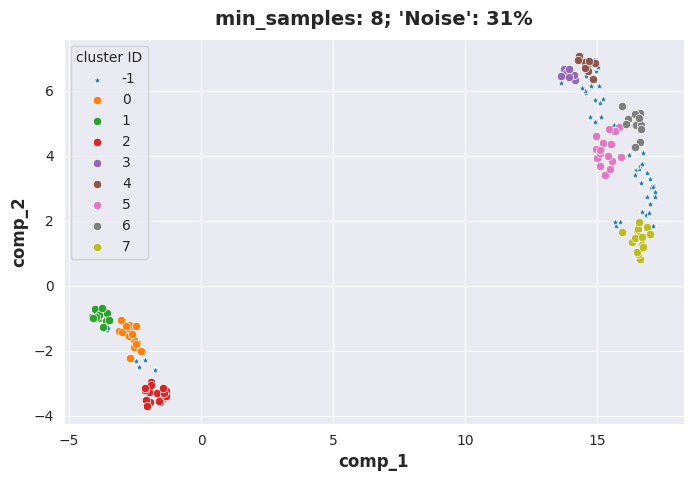

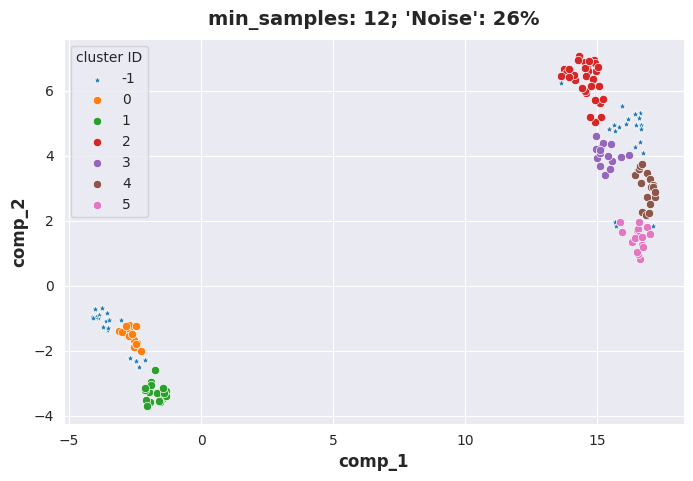

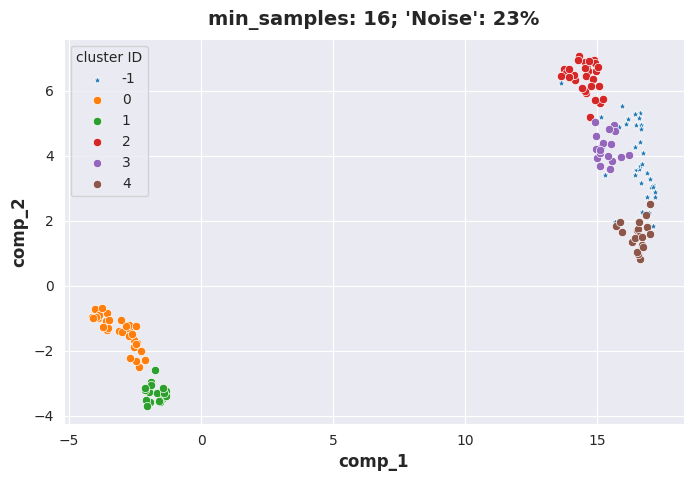

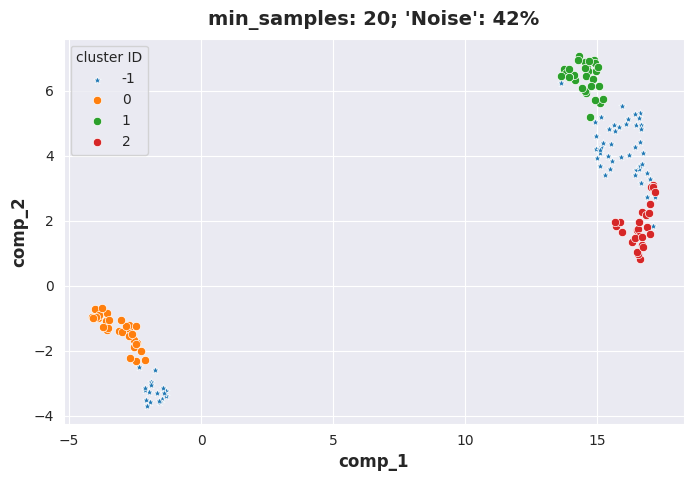

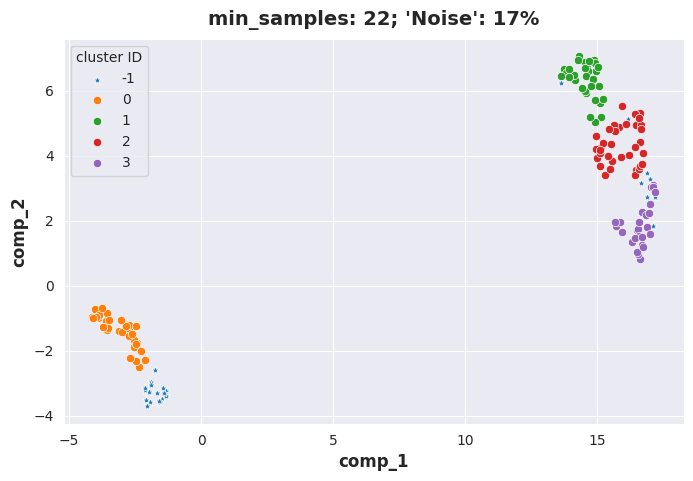

CPU times: user 6.48 s, sys: 1.13 s, total: 7.61 s
Wall time: 14.6 s


In [233]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

==> An approprate value for *min_samples* would be around 20.

### Re-run with optimised *min_samples*

In [234]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 554 ms, sys: 154 ms, total: 708 ms
Wall time: 2.14 s


# Comparison of training times

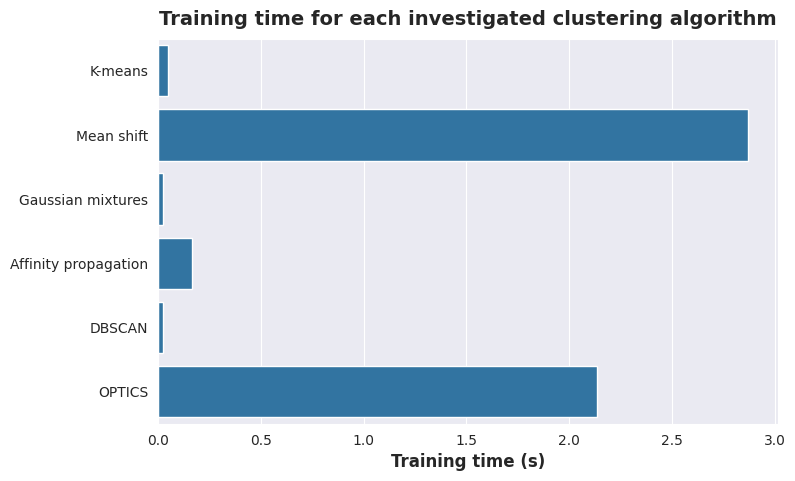

In [235]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

==> The training times across the investigated algorithms **vary considerably**! On the scale of the training times for the Mean shift and OPTICS algorithms, the training times of the other algos practically vanish. Interestingly enough though, when allowing for data points to be considered as "noise" for the Mean shift algo, its training time reduced substantially. For the following, its training time for *cluster_all=False* is taken as its relevant time. Furthermore, OPTICS is excluded so to allow for a comparison of the training times of the remaining algos on a more sensible scale.

In [236]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

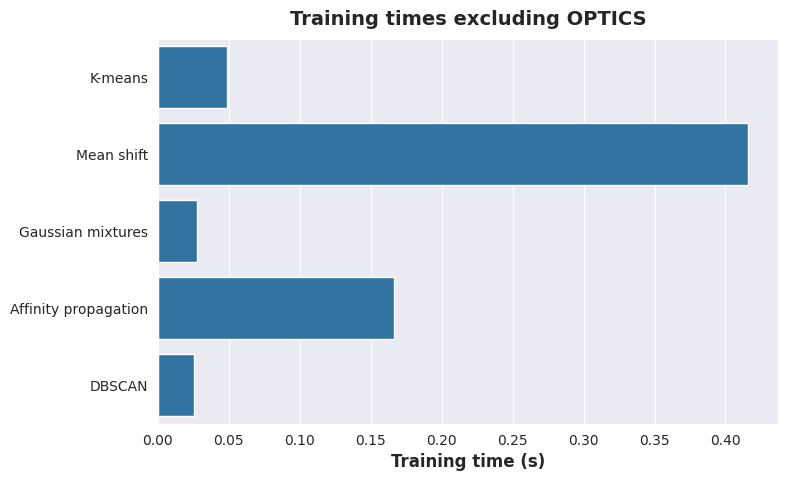

In [237]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding OPTICS")
plt.xlabel("Training time (s)")
plt.show()

# Conclusions

As with practically everything else in the machine learning domain, when it comes to clustering there is no "one-size-fits-all" algorithm. Different algorithms tend to be better depending on the structure of the data and in particluar **to what extent this structure is in line with what each algorithm relies on in order to work satisfactorily**. For the relatively simple data structure of the "wine dataset", practically all investigated algorithms performed well (after more or less hyperparameter turning).

Two important caveats regarding the results of this "study":
- Only the **single "most important" hyperparameter** was considered for tuning for each algorithm.
- The **dataset** employed here is **very small**. For datasets of a more real-world size, the relative performance in terms of training times will most likely be different.